# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [10]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy.linalg import inv

image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

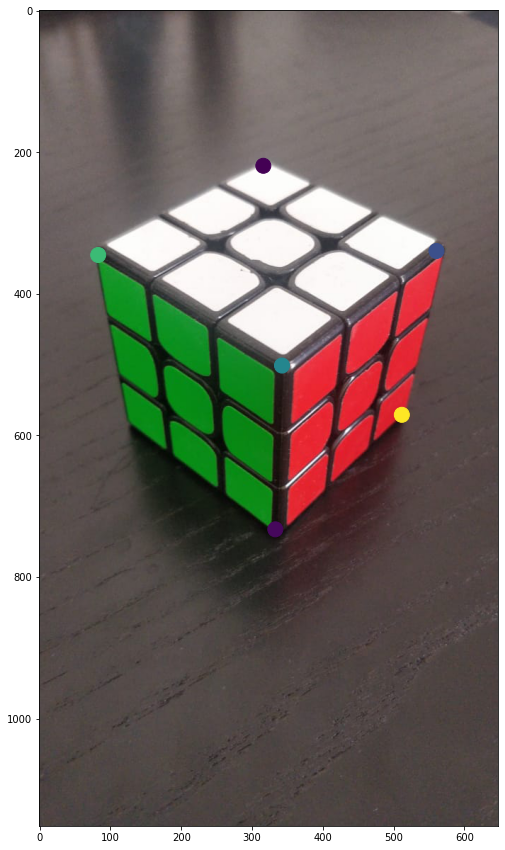

In [11]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [13]:
#We'll rename image_points to x to match textbook convention
x = image_points
print("Image points : \n",x)
# X represents the 3D world points
X = [[0,0,0],[4,0,0],[4,4,0],[0,4,0],[4,0,4], [4,4,4]]
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])

X = np.array(X)
print("3D World points : \n",X)

Image points : 
 [[ 82.67884061 345.07836372]
 [342.31415308 501.23583427]
 [560.55832877 339.4341178 ]
 [315.97433877 219.02353811]
 [332.90707654 732.64991712]
 [511.64153077 570.84820065]]
3D World points : 
 [[0 0 0]
 [4 0 0]
 [4 4 0]
 [0 4 0]
 [4 0 4]
 [4 4 4]]


Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [14]:
#Helper functions
#appends a ones column to input
def hom_coords(x,X):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

x,X = hom_coords(x,X)

#### Explanation

Edit this cell and explain the DLT algorithm:

In [15]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    A = []
    n = X.shape[0] 
    #for k in range(0,n): n = 6
    for i in range(n):
        xt,yt,zt = X[i,0],X[i,1],X[i,2]
        u,v = x[i,0],x[i,1]
        A.append( [-xt, -yt, -zt, -1, 0, 0, 0, 0, u * xt, u * yt, u * zt, u] )
        A.append( [0, 0, 0, 0, -xt, -yt, -zt, -1, v * xt, v * yt, v * zt, v] )
    
    # Convert A to array
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A) 
    P = V[-1,:]/V[-1,-1]
    #P = np.random.randn(3,4)
    P = P.reshape(3,4)
    
    return P

P = DLT(x,X)
print('Projection matrix : \n' , P , type(P) , P.shape)

Projection matrix : 
 [[ 5.57749909e+01  7.10355089e+01  1.74521966e+01  8.26001038e+01]
 [ 2.56659789e+01 -2.26550055e+01  9.47525139e+01  3.44929584e+02]
 [-2.69294518e-02  4.01051457e-02  5.90570537e-02  1.00000000e+00]] <class 'numpy.ndarray'> (3, 4)


## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [16]:
#Get reprojected points

def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    N = len(x)
    #print(N)
    diff = x[:,0:2] - points
    err = (1/N)*np.sum(diff**2)
    #to err is to human
    return err

print('Reprojection error : ' , get_err(x,X,P))

Reprojection error :  0.0931727241589976


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [17]:
from numpy.linalg import inv
def GetMMatrix(P):
    M = P[: , 0:3] 
    #print('printing M = KR','\n' ,M ,type(M))
    return M

def GetRotationMatrix(K,M):
    R = np.dot(inv(K),M) # M = KR
    return(R)
    
def GetTranslationMatrix(K,P):
    p4 = P[:,3]
    #print('p4','\n', p4,'\n')
    t = np.dot(inv(K),p4)
    return t

def ret_RKT(P):
    """
    """
    M = GetMMatrix(P)#KR
    M1 =np.transpose(M)#(KR)^T   
    M2 = np.dot(M,M1)# M2 = KR*(KR)^T gives K*K^T
    x0 = M2[0,2]
    y0 = M2[1,2]
    fy = np.sqrt(M2[1,1]-np.square(y0))
    s = (M2[0,1] -x0*y0)/fy
    fx = np.sqrt(M2[0,0]-np.square(s)-np.square(x0))
    K = np.array([[fx,s,x0],[0,fy,y0],[0,0,1]])
    R = GetRotationMatrix(K,M)
    T = GetTranslationMatrix(K,P)
    
    return R, K , T 

R, K , T = ret_RKT(P)
print('Rotation : \n', R)
print('K : \n' ,K)
print('Translation : \n',T)

Rotation : 
 [[ 0.57393005  0.81768598  0.04004331]
 [ 0.25602545 -0.22663855  0.93889264]
 [-0.02692945  0.04010515  0.05905705]]
K : 
 [[ 90.79452677  14.56617129   2.37757482]
 [  0.         100.66807938   3.99605127]
 [  0.           0.           1.        ]]
Translation : 
 [0.34023129 3.38670942 1.        ]


Reproject the world points with P matrix you have obtained via DLT:

Image points with new P : 
 [[ 82.60010381 344.9295844 ]
 [342.60469378 501.62774009]
 [560.31209995 339.10186823]
 [316.04242866 219.1529228 ]
 [332.74735561 732.47313422]
 [511.78138642 571.00305503]]


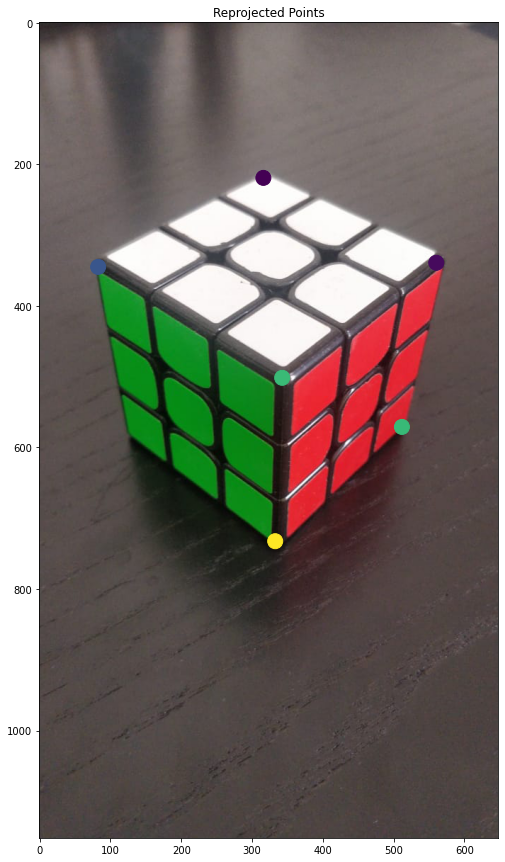

In [18]:
re_proj = get_points(P, X)
print('Image points with new P : \n', re_proj)
#code to plot these on the image
fig = plt.figure(figsize=(10,15))
img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area)
plt.title("Reprojected Points")
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

In [19]:
#Code for zhangs here
import numpy as np
import cv2
import glob
import shutil
import os

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

obj_points = [] # 3d world points
img_points = []

obj_w = np.zeros((8*6,3), np.float32)
obj_w[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

zhang_images = glob.glob('Images/Zhangs/*.JPG')
path = 'Zhang_out'
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path) 
i = 5455
for image in zhang_images:
    img = cv2.imread(image)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img_gray, (8,6),None)
    i = i+1
    if ret == True:
        obj_points.append(obj_w)

        corners2 = cv2.cornerSubPix(img_gray,corners,(11,11),(-1,-1),criteria)
        img_points.append(corners2)
        # Draw and display the corners
        img_corner = cv2.drawChessboardCorners(img, (8,6), corners2,ret)
        #print(img_corner)
        cv2.imwrite('Zhang_out/IMG_'+ str(i) +'_corners.JPG', img_corner)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()
reproj, K_mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_gray.shape[::-1],None,None)

print('Reprojection error : ',reproj , '\n')
print('K camera matrix using Zhang : \n', K_mtx , '\n')

Reprojection error :  2.28841514554369 

K camera matrix using Zhang : 
 [[1.36415095e+04 0.00000000e+00 3.31635924e+03]
 [0.00000000e+00 1.36632518e+04 1.50037425e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 



---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [20]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:
##### Task 1 :
1. Let $x , x^/$ are the points of image 1 and image 2.
2. $l$ are the epipolar lines in image 1 of image 2 points. Similarly, $l^/$ are the epipolar lines in image 2 of image1 points.
3. The fundamental matrix satisfies the condition that for any pair of corresponding points $x <-> x^/$,
$x^{/T}Fx = 0$
4. $l^/ = Fx$ is the epipolar line in image 2, and if $x^/$ points on that line $l^/$, it satisifes : $x^{/T}Fx = x^{/T}l^/ = 0 $
5. $l = x^{/T}F$ is the epipolar line in image 1, and if $x$ points on that line $l$, it satisifes : $x^{/T}Fx = lx = 0 $

#### Task 2 :
An epipole is the point of intersection of the line joining the camera centres (the
baseline) with the image plane.  
Similar to Task 1, here it satisfies :
1. $Fe = 0$
2. $e^{/T}F = 0$

It can be also seen as, 
1. epipole $e$ is the point of interestion of epipolar lines $l$ in image 1 for points $x^/$ of image2
1. epipole $e^/$ is the point of interestion of epipolar lines $l^/$ in image 2 for points $x$ of image1

Epipoles in Image 1 : [2159.16628178 1189.26810563], Image 2 : [-5131.90964076  -948.85463472]


<Figure size 2160x1440 with 0 Axes>

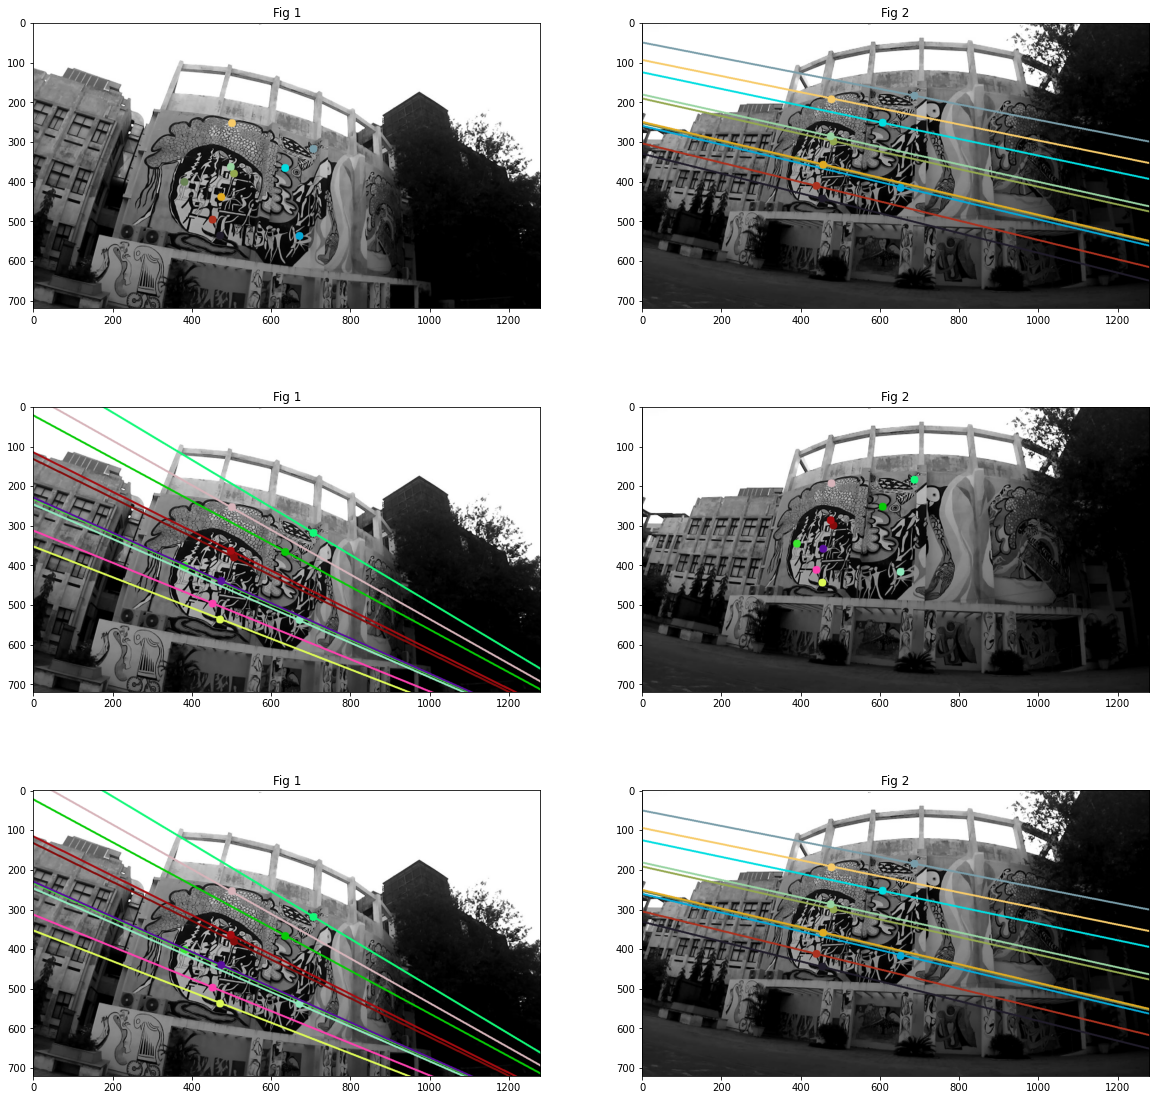

In [21]:
#Write code to plot epipolar lines on the images
import cv2
def epiline(F_mat, pt, i):
    pt,_ = hom_coords(pt,pt)
    if i==1:
        l = (F_mat @ pt.T).T
    if i==2 :
        l = (F_mat.T @ pt.T).T
    return l

def epipole(F):
        im1 = np.linalg.solve(F,np.array([0,0,1]))
        im2 = np.linalg.solve(F.T,np.array([0,0,1]))
        im1 = im1 / im1[2]
        im2 = im2 / im2[2]
        return im1[:2], im2[:2]
    
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ]) # line = [a,b,c], (0,-c/b)
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ]) # -(c+a*w)/b
        pt1 = pt1.astype(int)
        pt2 = pt2.astype(int)
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,4)
        img1 = cv2.circle(img1,tuple(pt1),10,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),10,color,-1)
    return img1,img2
  
if __name__ == '__main__':
    pt1 = img_1
    pt2 = img_2
    img1 = cv2.imread('q2/img1.jpg',0)
    img2 = cv2.imread('q2/img2.jpg',0)
    h1,w1 = img1.shape
    h2,w2= img2.shape
    im1, im2 = epipole(F_mat)
    print("Epipoles in Image 1 : {}, Image 2 : {}".format(im1, im2))
    if h1!=h2 and w1!=w2:
        print("Dimension mismatch of both the images")
        
    # epipolar line in fig2 for given points in fig1
    lines1 = epiline(F_mat, pt1, 1)
    lines1 = lines1.reshape(-1,3)
    e_imgR1,imgL1 = drawlines(img2,img1,lines1,pt2,pt1)
    
    # epipolar line in fig1 for given points in fig2
    lines2 = epiline(F_mat, pt2, 2)
    lines2 = lines2.reshape(-1,3)
    e_imgL2,imgR2 = drawlines(img1,img2,lines2,pt1,pt2)
    
    plt.figure(figsize=(30,20))
    f, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize=(20,20))
    ax1.imshow(imgL1)
    ax1.set_title("Fig 1")
    ax2.imshow(e_imgR1)
    ax2.set_title("Fig 2")
    ax3.imshow(e_imgL2)
    ax3.set_title("Fig 1")
    ax4.imshow(imgR2)
    ax4.set_title("Fig 2")
    ax5.imshow(e_imgL2)
    ax5.set_title("Fig 1")
    ax6.imshow(e_imgR1)
    ax6.set_title("Fig 2")
    plt.show()
    

#### Task 2
Report the location of the epipoles.

An epipole is the point of intersection of the line joining the camera centres (the baseline) with the image plane.
In this case, both epipoles lie outside of the visible image.
1. Epipoles in Image 1 : [2159.16628178, 1189.26810563], 
2. Epipoles in Image 2 : [-5131.90964076,  -948.85463472]